In [1]:
# Import packages
%load_ext autoreload
%autoreload 2
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Box2DKernel, Gaussian2DKernel

plt.rcParams['font.size'] = 15
plt.rc('image', cmap='inferno', interpolation='none', origin='lower')

## Download image

In [2]:
import dill, sys
sys.setrecursionlimit(10000)

In [3]:
from kuaizi.detection import Data
kz.utils.set_env(project='HSC', name='LSBG', data_dir='/tiger/scratch/gpfs/jiaxuanl/Data')

'/tiger/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [4]:
lsbg_cat = Table.read('./Cutout/Candy/candy_cutout_cat.fits')

In [5]:
# Download images and PSFs from HSC database
lsbg = lsbg_cat[47]
prefix = 'LSBG'
index = lsbg['Seq']
lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
print(f'### Running scarlet wavelet modeling for `{lsbg["prefix"]}`')

bright = (lsbg['mag_auto_i'] < 17)
print('Bright =', bright)

channels = 'griz'

cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

### Running scarlet wavelet modeling for `/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_47`
Bright = True


In [6]:
# Reconstructure data
from kuaizi.utils import padding_PSF

images = np.array([hdu[1].data for hdu in cutout])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
data = Data(images=images, weights=weights, wcs=w, psfs=psfs, channels=channels)

In [94]:
import unagi

In [154]:
sat_mask = np.array([sum(unagi.mask.Mask(hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
sat_mask = np.sum(sat_mask, axis=0).astype(bool)

In [155]:
sat_mask.shape

(1071, 1071)

# Detect sources

In [21]:
pixel_scale = 0.168

In [22]:
print('  - Detect sources and make mask')
print('    Query GAIA stars...')
gaia_cat, msk_star = kz.utils.gaia_star_mask(  # Generate a mask for GAIA bright stars
    data.images.mean(axis=0),  # averaged image
    data.wcs,
    pixel_scale=pixel_scale,
    gaia_bright=19.5, # 18.5
    mask_a=694.7,
    mask_b=3.8,
    factor_b=0.7,
    factor_f=1.0,
    tigress=True,
    logger=None)

  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    33 stars from Gaia are masked!


    Detected 350 objects


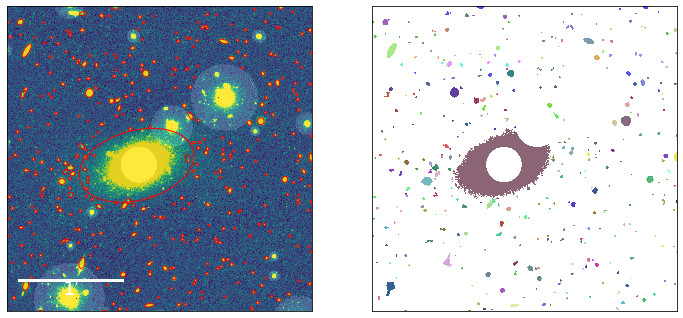

In [23]:
# This vanilla detection with very low sigma finds out where is the central object and its footprint
obj_cat_ori, segmap_ori, bg_rms = kz.detection.makeCatalog(
    [data],
    lvl=2,
    mask=msk_star,
    method='vanilla',
    convolve=False,
    match_gaia=False,
    show_fig=True,
    visual_gaia=False,
    b=128,
    f=3,
    pixel_scale=pixel_scale,
    minarea=20,
    deblend_nthresh=48,
    deblend_cont=0.07,  # 0.07, I changed it to 0.1
    sky_subtract=True,
    logger=None)

catalog_c = SkyCoord(obj_cat_ori['ra'], obj_cat_ori['dec'], unit='deg')
dist = lsbg_coord.separation(catalog_c)
cen_indx_ori = obj_cat_ori[np.argsort(dist)[0]]['index']
cen_obj = obj_cat_ori[cen_indx_ori]

# Better position for cen_obj
x, y, _ = sep.winpos(data.images.mean(
    axis=0), cen_obj['x'], cen_obj['y'], 6)
ra, dec = data.wcs.wcs_pix2world(x, y, 0)
cen_obj['x'] = x
cen_obj['y'] = y
cen_obj['ra'] = ra
cen_obj['dec'] = dec
cen_obj_coord = SkyCoord(cen_obj['ra'], cen_obj['dec'], unit='deg')

In [24]:
# We roughly guess the box size of the Starlet model
model_psf = scarlet.GaussianPSF(sigma=(0.8,) * len(data.channels))
model_frame = scarlet.Frame(
    data.images.shape,
    wcs=data.wcs,
    psf=model_psf,
    channels=list(data.channels))
observation = scarlet.Observation(
    data.images,
    wcs=data.wcs,
    psf=data.psfs,
    weights=data.weights,
    channels=list(data.channels))
observation = observation.match(model_frame)

cen_obj = obj_cat_ori[cen_indx_ori]
starlet_source = scarlet.StarletSource(model_frame,
                                       (cen_obj['ra'], cen_obj['dec']),
                                       observation,
                                       thresh=0.01,
                                       min_grad=-0.1,  # the initial guess of box size is as large as possible
                                       starlet_thresh=5e-3)

# If the initial guess of the box is way too large (but not bright galaxy), set min_grad = 0.1.
if starlet_source.bbox.shape[1] > 0.6 * data.images[0].shape[0] and (~bright):
    starlet_source = scarlet.StarletSource(model_frame,
                                           (cen_obj['ra'], cen_obj['dec']),
                                           observation,
                                           thresh=0.01,
                                           min_grad=0.07,  # the initial guess of box size is as large as possible
                                           starlet_thresh=5e-3)
    small_box = True
else:
    small_box = False

starlet_extent = kz.display.get_extent(
    starlet_source.bbox)  # [x1, x2, y1, y2]
# extra enlarge
starlet_extent[0] -= 5
starlet_extent[2] -= 5
starlet_extent[1] += 5
starlet_extent[3] += 5

[array([ 3983.6738,  4934.0107,  1197.8599, 12069.421 ], dtype=float32)]


In [25]:
small_box

False

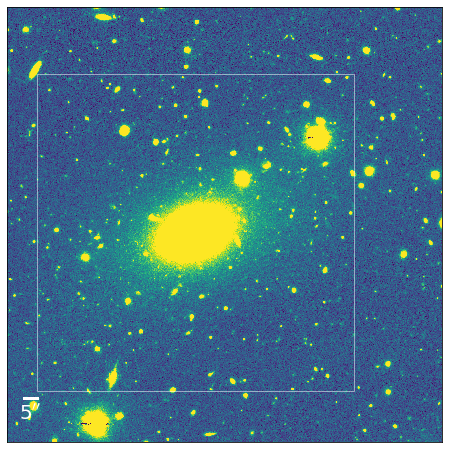

In [26]:
# Show the Starlet initial box
fig = display_single(data.images.mean(axis=0))
from matplotlib.patches import Rectangle
box_kwargs = {"facecolor": "none", "edgecolor": "w", "lw": 0.5}
rect = Rectangle(
    (starlet_extent[0], starlet_extent[2]),
    starlet_extent[1] - starlet_extent[0],
    starlet_extent[3] - starlet_extent[2],
    **box_kwargs
)
ax = plt.gca()
ax.add_patch(rect)

In [27]:
if gaia_cat is not None:
    star_flag = [(item[0] > starlet_extent[0]) & (item[0] < starlet_extent[1]) &
                 (item[1] > starlet_extent[2]) & (
                     item[1] < starlet_extent[3])
                 for item in np.asarray(
        data.wcs.wcs_world2pix(gaia_cat['ra'], gaia_cat['dec'], 0), dtype=int).T]
    # "star_cat" is a catalog for GAIA stars which fall in the Starlet box
    star_cat = gaia_cat[star_flag]

    _, msk_star = kz.utils.gaia_star_mask(  # Generate GAIA mask only for stars outside of the Starlet box
        data.images.mean(axis=0),
        data.wcs,
        gaia_stars=gaia_cat[~np.array(star_flag)],
        pixel_scale=pixel_scale,
        gaia_bright=19.5,
        mask_a=694.7,
        mask_b=3.8,
        factor_b=1.0,
        factor_f=0.6,
        tigress=True,
        logger=None)
else:
    star_cat = []

    27 stars from Gaia are masked!


    Detected 710 objects


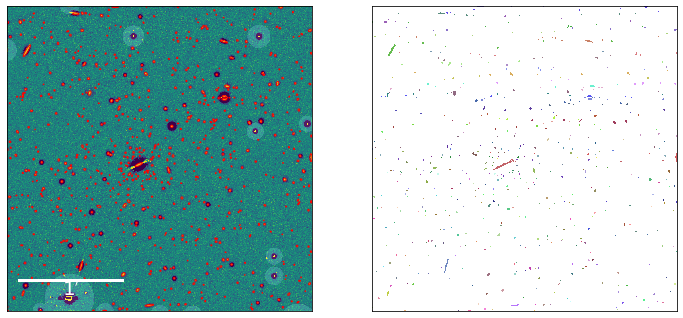

In [28]:
# This step masks out high frequency sources by doing wavelet transformation
obj_cat, segmap_highfreq, bg_rms = kz.detection.makeCatalog([data],
                                                            mask=msk_star,
                                                            lvl=2.,  # 2.5
                                                            method='wavelet',
                                                            high_freq_lvl=2,  # 3
                                                            wavelet_lvl=4,
                                                            match_gaia=False,
                                                            show_fig=True,
                                                            visual_gaia=False,
                                                            b=24,
                                                            f=3,
                                                            pixel_scale=pixel_scale,
                                                            minarea=3,
                                                            deblend_nthresh=30,
                                                            deblend_cont=0.03,
                                                            sky_subtract=True,
                                                            logger=None)

catalog_c = SkyCoord(obj_cat['ra'], obj_cat['dec'], unit='deg')
dist = cen_obj_coord.separation(catalog_c)
cen_indx_highfreq = obj_cat[np.argsort(dist)[0]]['index']

# Don't mask out objects that fall in the segmap of the central object and the Starlet box
segmap = segmap_highfreq.copy()
# overlap_flag is for objects which fall in the footprint of central galaxy in the fist SEP detection
overlap_flag = [(segmap_ori == (cen_indx_ori + 1))[item]
                for item in list(zip(obj_cat['y'].astype(int), obj_cat['x'].astype(int)))]
overlap_flag = np.array(overlap_flag)
# box_flat is for objects which fall in the initial Starlet box
box_flag = np.unique(
    segmap[starlet_extent[2]:starlet_extent[3], starlet_extent[0]:starlet_extent[1]]) - 1
if len(box_flag) > 0:
    box_flag = np.delete(np.sort(box_flag), 0)
    overlap_flag[box_flag] = True
if len(overlap_flag) > 0:
    obj_cat_cpct = obj_cat[overlap_flag]

# Remove the source if it is the central galaxy
if dist[cen_indx_highfreq] < 1 * u.arcsec:
    obj_cat_cpct.remove_rows(
        np.where(obj_cat_cpct['index'] == cen_indx_highfreq)[0])

for ind in np.where(overlap_flag)[0]:
    segmap[segmap == ind + 1] = 0

smooth_radius = 2
gaussian_threshold = 0.03
mask_conv = np.copy(segmap)
mask_conv[mask_conv > 0] = 1
mask_conv = convolve(mask_conv.astype(
    float), Gaussian2DKernel(smooth_radius))
# This `seg_mask` only masks compact sources
seg_mask = (mask_conv >= gaussian_threshold)

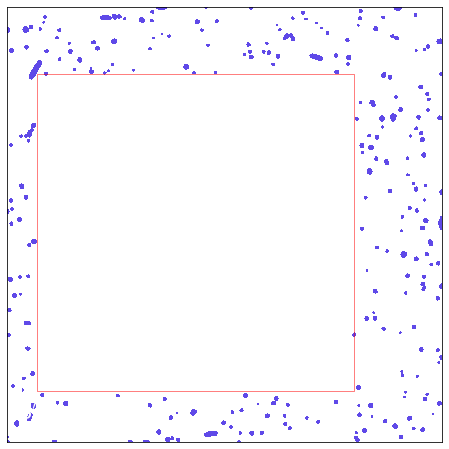

In [29]:
fig = display_single(seg_mask.astype(float), cmap=SEG_CMAP, scale='linear')
from matplotlib.patches import Rectangle
box_kwargs = {"facecolor": "none", "edgecolor": "r", "lw": 0.5}
rect = Rectangle(
    (starlet_extent[0], starlet_extent[2]),
    starlet_extent[1] - starlet_extent[0],
    starlet_extent[3] - starlet_extent[2],
    **box_kwargs
)
#print(rect)
ax = plt.gca()
ax.add_patch(rect)

    Detected 236 objects


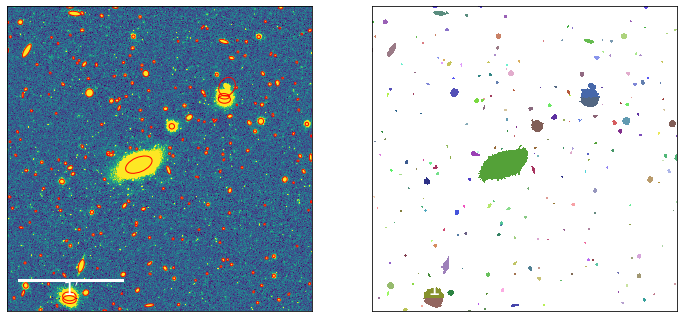

In [30]:
# This step masks out bright and large contamination, which is not well-masked in previous step
obj_cat, segmap_big, bg_rms = kz.detection.makeCatalog(
    [data],
    lvl=4.5,  # relative agressive threshold
    method='vanilla',
    match_gaia=False,
    show_fig=True,
    visual_gaia=False,
    b=32,
    f=3,
    pixel_scale=pixel_scale,
    minarea=20,   # only want large things
    deblend_nthresh=30,
    deblend_cont=0.01,
    sky_subtract=True,
    logger=None)

catalog_c = SkyCoord(obj_cat['ra'], obj_cat['dec'], unit='deg')
dist = cen_obj_coord.separation(catalog_c)
cen_indx_big = obj_cat_ori[np.argsort(dist)[0]]['index']

# mask out big objects that are NOT identified in the high_freq step
segmap = segmap_big.copy()
box_flag = np.unique(
    segmap[starlet_extent[2]:starlet_extent[3], starlet_extent[0]:starlet_extent[1]]) - 1
if len(box_flag) > 0:
    box_flag = np.delete(np.sort(box_flag), 0)
    for ind in box_flag:
        segmap[segmap == ind + 1] = 0
    box_flag = np.delete(box_flag, np.where(box_flag == cen_indx_big)[
        0])  # dont include the central galaxy
    obj_cat_big = obj_cat[box_flag]
else:
    obj_cat_big = obj_cat

smooth_radius = 5
gaussian_threshold = 0.01
mask_conv = np.copy(segmap)
mask_conv[mask_conv > 0] = 1
mask_conv = convolve(mask_conv.astype(
    float), Gaussian2DKernel(smooth_radius))
# This `seg_mask_large` masks large bright sources
seg_mask_large = (mask_conv >= gaussian_threshold)

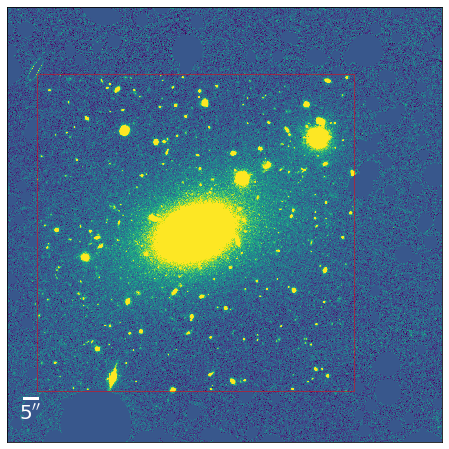

In [31]:
fig = display_single(data.images[2] * (~(seg_mask_large + seg_mask + msk_star.astype(bool))))
from matplotlib.patches import Rectangle
box_kwargs = {"facecolor": "none", "edgecolor": "r", "lw": 0.5}
rect = Rectangle(
    (starlet_extent[0], starlet_extent[2]),
    starlet_extent[1] - starlet_extent[0],
    starlet_extent[3] - starlet_extent[2],
    **box_kwargs
)
#print(rect)
ax = plt.gca()
ax.add_patch(rect)
#display_single(data.images[0] * (~(seg_mask_large + msk_star.astype(bool))));

In [32]:
# Set weights of masked pixels to zero
for layer in data.weights:
    layer[msk_star.astype(bool)] = 0
    layer[seg_mask.astype(bool)] = 0
    layer[seg_mask_large.astype(bool)] = 0

In [33]:
# Remove compact objects that are too close to the central
catalog_c = SkyCoord(obj_cat_cpct['ra'], obj_cat_cpct['dec'], unit='deg')
dist = cen_obj_coord.separation(catalog_c)
obj_cat_cpct.remove_rows(np.where(dist < 3 * u.arcsec)[0])
# Remove objects that are already masked!
inside_flag = [
    seg_mask_large[item] for item in list(
        zip(obj_cat_cpct['y'].astype(int), obj_cat_cpct['x'].astype(int)))
]
obj_cat_cpct.remove_rows(np.where(inside_flag)[0])
# Remove big objects that are toooo near to the target
catalog_c = SkyCoord(obj_cat_big['ra'], obj_cat_big['dec'], unit='deg')
dist = cen_obj_coord.separation(catalog_c)
#obj_cat_big.remove_rows(np.where(dist < 3 * u.arcsec)[0])
obj_cat_big.remove_rows(np.where(
    dist < 2 * np.sqrt(cen_obj['a'] * cen_obj['b']) * pixel_scale * u.arcsec)[0])
# Remove objects that are already masked!
inside_flag = [
    (data.weights[0] == 0)[item] for item in list(
        zip(obj_cat_big['y'].astype(int), obj_cat_big['x'].astype(int)))
]
obj_cat_big.remove_rows(np.where(inside_flag)[0])

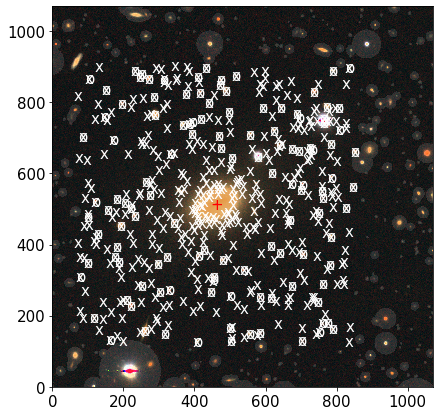

In [34]:
# Visualize our data
from scarlet.display import AsinhMapping

stretch = 2
Q = 1
img_rgb = scarlet.display.img_to_rgb(data.images, norm=AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q))
weights = data.weights
mask = (np.sum(data.weights == 0, axis=0) != 0)

fig, ax = plt.subplots(figsize=(7, 7))
plt.imshow(img_rgb)
plt.imshow(mask.astype(float), origin='lower', alpha=0.1, cmap='Greys_r')

# Mark all of the sources from the detection cataog
plt.text(cen_obj["x"], cen_obj["y"], '+', color="red", horizontalalignment='center', verticalalignment='center')
for k, src in enumerate(obj_cat_cpct):
    plt.text(src["x"], src["y"], 'x', color="w", horizontalalignment='center', verticalalignment='center') # src['index']
    
for k, src in enumerate(obj_cat_big):
    plt.text(src["x"], src["y"], 'o', color="w", horizontalalignment='center', verticalalignment='center') # src['index']

# Model selection

In [157]:
starlet_thresh = 0.5

In [173]:
# Construct `scarlet` frames and observation
model_psf = scarlet.GaussianPSF(sigma=(0.8,) * len(data.channels))
model_frame = scarlet.Frame(
    data.images.shape,
    wcs=data.wcs,
    psf=model_psf,
    channels=list(data.channels))
observation = scarlet.Observation(
    data.images,
    wcs=data.wcs,
    psf=data.psfs,
    weights=data.weights,
    channels=list(data.channels))
observation = observation.match(model_frame)

In [116]:
sources = []

# Add central Starlet source
src = obj_cat_ori[cen_indx_ori]
# Find a better box, not too large, not too small
if small_box:
    min_grad_range = np.arange(0.1, 0.4, 0.05)
else:
    min_grad_range = np.arange(-0.3, 0.4, 0.05)

stlt_src_center = scarlet.StarletSource(
    model_frame,
    (src['ra'], src['dec']),
    observation,
    thresh=1,
    min_grad=0.1,
    starlet_thresh=starlet_thresh)

ref_sed = 27.0 - 2.5 * np.log10(kz.measure.flux(stlt_src_center, observation))

# for min_grad in min_grad_range:
#     starlet_source = scarlet.StarletSource(
#         model_frame,
#         (src['ra'], src['dec']),
#         observation,
#         thresh=0.01,
#         min_grad=min_grad,
#         starlet_thresh=starlet_thresh)
    
#     starlet_extent = kz.display.get_extent(starlet_source.bbox)
#     segbox = segmap_ori[starlet_extent[2]:starlet_extent[3],
#                         starlet_extent[0]:starlet_extent[1]]
#     contam_ratio = 1 - \
#         np.sum((segbox == 0) | (segbox == cen_indx_ori + 1)) / \
#         np.sum(np.ones_like(segbox))
    
#     sed = 27.0 - 2.5 * np.log10(kz.measure.flux(starlet_source, observation))
    
#     color_dist = np.linalg.norm(sed - ref_sed) / np.linalg.norm(sed)
    
#     if contam_ratio <= 0.10 and color_dist < 0.05:
#         break
        
# print(f'  - Wavelet modeling with the following hyperparameters:')
# print(
#     f'    min_grad = {min_grad:.2f}, starlet_thresh = {starlet_thresh:.2f} (contam_ratio = {contam_ratio:.2f}).'
# )
# print(
#     f'    sed diff = {(sed - ref_sed)}, sed diff fraction = {color_dist:.2f}.'
# )

# starlet_source.center = (
#     np.array(starlet_source.bbox.shape) // 2 + starlet_source.bbox.origin)[1:]
# sources.append(starlet_source)


[137.38817 285.50986 256.1814  622.0093 ]


In [161]:
src = obj_cat_ori[cen_indx_ori]
new_source = scarlet.source.SingleExtendedSource(
            model_frame, (src['ra'], src['dec']), observation, thresh=1, shifting=False, min_grad=0.0)

[148.09549 306.85797 275.88052 673.7423 ]


In [175]:
sat_mask = np.array([sum(unagi.mask.Mask(hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
#sat_mask = np.sum(sat_mask, axis=0).astype(bool)

In [180]:
src = obj_cat_ori[cen_indx_ori]
new_source = scarlet.source.SingleExtendedSource(
            model_frame, (src['ra'], src['dec']), observation, sat_mask=sat_mask, thresh=1, shifting=False, min_grad=0.0)

[0.3678677, 0.3201998, 0.22881447, 0.35531476]
[23.742054 47.65587  69.00302  89.39122 ] 0.3180492
[146.40933 293.87784 425.51862 551.24585]
[146.40933 293.87784 425.51862 551.24585]


In [179]:
np.array([23.742054, 47.65587,  69.0030,  89.39122 ]) * (148/24)

array([146.409333  , 293.877865  , 425.5185    , 551.24585667])

In [168]:
sat_mask.shape

(1071, 1071)

In [172]:
new_source.parameters[1].sum()

Parameter(223.82425, dtype=float32)

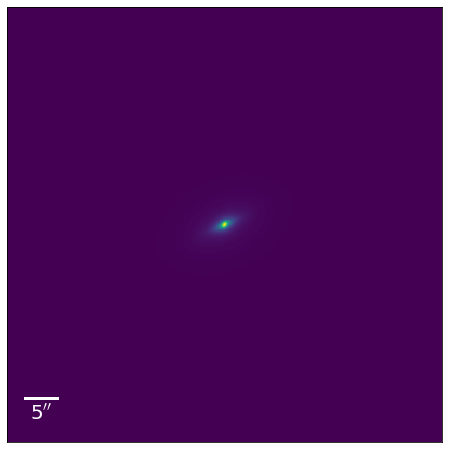

In [178]:
display_single(new_source.parameters[1], scale='linear');

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

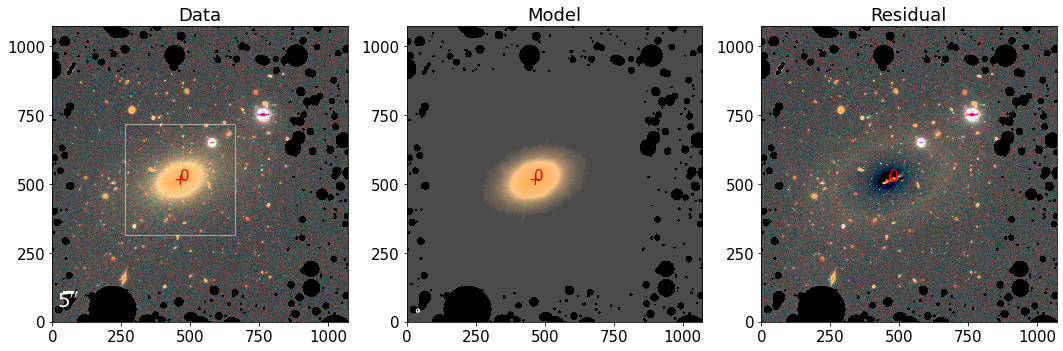

In [181]:
blend = scarlet.Blend([new_source], observation)
kz.display.display_scarlet_model(
    blend,
    #show_ind=[0, 1],
    #zoomin_size=80,
    minimum=-0.3,
    stretch=1,
    add_boxes=True,
    channels=channels,
    show_mask=True,
    show_mark=True)

In [247]:
# for min_grad in np.arange(0., 0.4, 0.05):
#     starlet_source = scarlet.StarletSource(
#         model_frame,
#         (src['ra'], src['dec']),
#         observation,
#         thresh=0.01,
#         min_grad=min_grad,
#         starlet_thresh=1)
#     starlet_extent = kz.display.get_extent(starlet_source.bbox)
#     segbox = segmap_ori[starlet_extent[2]:starlet_extent[3], starlet_extent[0]:starlet_extent[1]]
#     contam_ratio = 1 - np.sum((segbox == 0) | (segbox == cen_indx_ori + 1)) / np.sum(np.ones_like(segbox))
#     if contam_ratio < 0.1:
#         break
# print(f'min_grad = {min_grad:.2f}, contam_ratio = {contam_ratio:.2f}')
# starlet_source.center = (np.array(starlet_source.bbox.shape) // 2 + starlet_source.bbox.origin)[1:]
# sources.append(starlet_source)


# Only model "real compact" sources
if len(obj_cat_big) > 0:
    # remove intersection between cpct and big objects
    cpct_coor = SkyCoord(
        ra=np.array(obj_cat_cpct['ra']) * u.degree,
        dec=np.array(obj_cat_cpct['dec']) * u.degree)
    big = SkyCoord(ra=obj_cat_big['ra'] * u.degree,
                   dec=obj_cat_big['dec'] * u.degree)
    tempid, sep2d, _ = match_coordinates_sky(big, cpct_coor)
    cpct = obj_cat_cpct[np.setdiff1d(
        np.arange(len(obj_cat_cpct)), tempid[np.where(sep2d < 1 * u.arcsec)])]
else:
    cpct = obj_cat_cpct

if len(star_cat) > 0:
    # remove intersection between cpct and stars
    star = SkyCoord(ra=star_cat['ra'], dec=star_cat['dec'], unit='deg')
    cpct_coor = SkyCoord(
        ra=np.array(cpct['ra']) * u.degree,
        dec=np.array(cpct['dec']) * u.degree)
    tempid, sep2d, _ = match_coordinates_sky(star, cpct_coor)
    cpct = cpct[np.setdiff1d(np.arange(len(cpct)),
                             tempid[np.where(sep2d < 1 * u.arcsec)])]

if not bright:  # for bright galaxy, we don't include these compact sources into modeling, due to the limited computational resources
    for k, src in enumerate(cpct):
        if src['fwhm_custom'] < 3:
            new_source = scarlet.source.PointSource(
                model_frame, (src['ra'], src['dec']), observation)
        elif src['fwhm_custom'] >= 3 and src['fwhm_custom'] < 5:
            new_source = scarlet.source.CompactExtendedSource(
                model_frame, (src['ra'], src['dec']), observation)
        else:
            new_source = scarlet.source.SingleExtendedSource(
                model_frame, (src['ra'], src['dec']), observation, thresh=2, min_grad=0.2)
        sources.append(new_source)

# IF GAIA stars are within the box: exclude it from the big_cat
if len(obj_cat_big) > 0:
    if len(star_cat) > 0:
        star = SkyCoord(ra=star_cat['ra'], dec=star_cat['dec'], unit='deg')
        tempid, sep2d, _ = match_coordinates_sky(star, big)
        big_cat = obj_cat_big[np.setdiff1d(
            np.arange(len(obj_cat_big)), tempid[np.where(sep2d < 1 * u.arcsec)])]
    else:
        big_cat = obj_cat_big

    # [np.where(sep2d > 2 * u.arcsec)[0]]
    for k, src in enumerate(big_cat):
        if src['fwhm_custom'] > 20:
            new_source = scarlet.source.ExtendedSource(
                model_frame, (src['ra'], src['dec']), observation, K=2, thresh=2, shifting=True, min_grad=0.2)
        else:
            # try:
            new_source = scarlet.source.SingleExtendedSource(
                model_frame, (src['ra'], src['dec']), observation, thresh=2, shifting=False, min_grad=0.2)
    #         except:
    #             new_source = scarlet.source.SingleExtendedSource(
    #                 model_frame, (src['ra'], src['dec']), observation, coadd=coadd, coadd_rms=bg_cutoff)
        sources.append(new_source)

if len(star_cat) > 0:
    for k, src in enumerate(star_cat):
        # if src['phot_g_mean_mag'] > 20:
        new_source = scarlet.source.SingleExtendedSource(
            model_frame, (src['ra'], src['dec']), observation, thresh=2, shifting=False, min_grad=0.1)
        # only use SingleExtendedSource
        # else:
        #     new_source = scarlet.source.ExtendedSource(
        #         model_frame, (src['ra'], src['dec']), observation, K=2, thresh=2, shifting=False, min_grad=0.2)

        sources.append(new_source)
        
print('Total number of sources:', len(sources))

Total number of sources: 123


[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

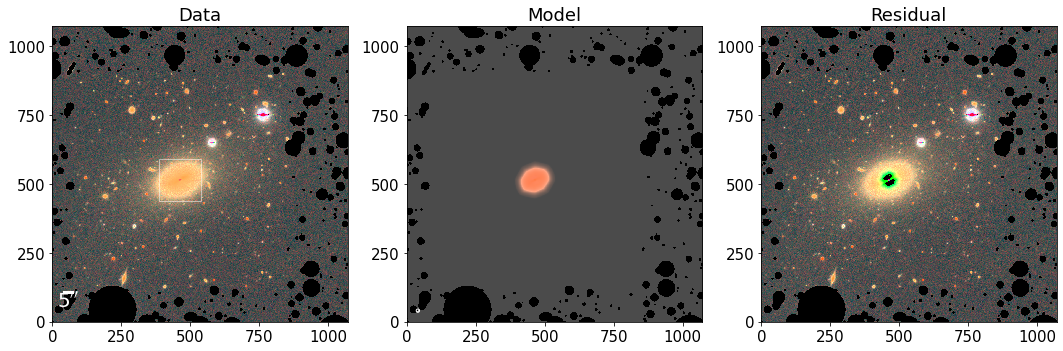

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

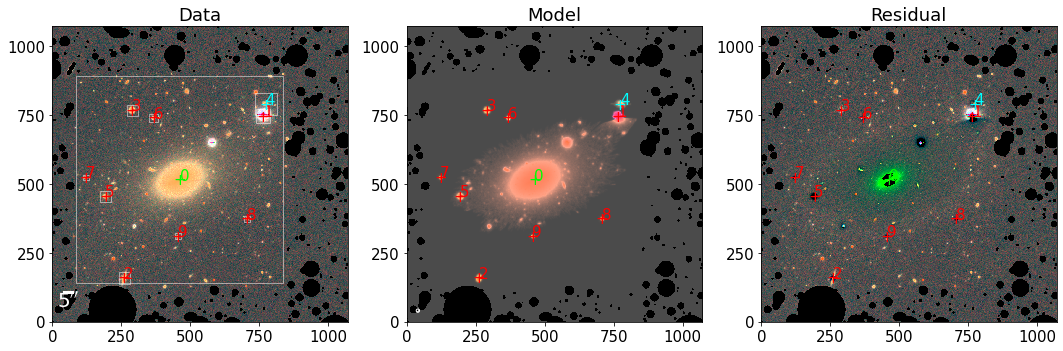

In [248]:
blend = scarlet.Blend(sources[:10], observation)
kz.display.display_scarlet_model(
    blend,
    #show_ind=[0, 1],
    #zoomin_size=80,
    minimum=-0.3,
    stretch=1,
    add_boxes=True,
    channels=channels,
    show_mask=True,
    show_mark=True)

In [133]:
source = [new_source]

In [134]:
model_dir = './Model/'

In [135]:
start = time.time()
if bright:
    e_rel_list = [5e-4, 1e-5]  # otherwise it will take forever....
else:
    e_rel_list = [5e-4, 1e-5, 5e-5, 1e-6]
blend.fit(150, 1e-4)
with open(os.path.join(model_dir, f'{prefix}-{index}-trained-model-wavelet.df'), 'wb') as fp:
    dill.dump([blend, {'starlet_thresh': starlet_thresh,
                       'e_rel': 1e-4, 'loss': blend.loss[-1]}, None], fp)
    fp.close()
last_loss = blend.loss[-1]
print(
    f'    Optimizaiton: Succeed for e_rel = 1e-04 with {len(blend.loss)} iterations! Try higher accuracy!')

for i, e_rel in enumerate(e_rel_list):
    blend.fit(150, e_rel)
    if len(blend.loss) > 50:  # must have more than 50 iterations
        recent_loss = np.mean(blend.loss[-10:])
        min_loss = np.min(blend.loss[:-10])
        if recent_loss < min_loss:
            print(
                f'    Optimizaiton: Succeed for e_rel = {e_rel} with {len(blend.loss)} iterations! Try higher accuracy!')
            with open(os.path.join(model_dir, f'{prefix}-{index}-trained-model-wavelet.df'), 'wb') as fp:
                dill.dump(
                    [blend, {'starlet_thresh': starlet_thresh, 'e_rel': e_rel, 'loss': blend.loss[-1]}, None], fp)
                fp.close()
        elif abs((recent_loss - min_loss) / min_loss) < 0.02:
            if recent_loss < last_loss:  # better than the saved model
                print(
                    f'    Optimizaiton: I am okay with relative loss difference = {abs((recent_loss - min_loss) / min_loss)}. Fitting stopped.')
                with open(os.path.join(model_dir, f'{prefix}-{index}-trained-model-wavelet.df'), 'wb') as fp:
                    dill.dump(
                        [blend, {'starlet_thresh': starlet_thresh, 'e_rel': e_rel, 'loss': blend.loss[-1]}, None], fp)
                    fp.close()
                break
        else:
            print(
                f'  ! Optimizaiton: Cannot achieve a global optimization with e_rel = {e_rel}.')
    else:
        continue
if len(blend.loss) < 50:
    print('  ! Might be poor fitting! Iterations less than 50.')
print("  - After {1} iterations, logL = {2:.2f}".format(
    e_rel, len(blend.loss), -blend.loss[-1]))
end = time.time()
print(f'    Elapsed time for fitting: {(end - start):.2f} s')


KeyboardInterrupt: 

In [213]:
# In principle, Now we don't need to find which components compose a galaxy. The central Starlet is enough!
if len(blend.sources) > 1:
    mag_mat = np.array(
        [-2.5 * np.log10(kz.measure.flux(src, observation)) + 27 for src in sources])
    # g - r, g - i, g - z
    color_mat = (- mag_mat + mag_mat[:, 0][:, np.newaxis])[:, 1:]
    color_dist = np.linalg.norm(
        color_mat - color_mat[0], axis=1) / np.linalg.norm(color_mat[0])
    sed_ind = np.where(color_dist < 0.1)[0]
    dist = np.array([
        np.linalg.norm(
            src.center - blend.sources[0].center) * pixel_scale
        for src in np.array(blend.sources)[sed_ind]
    ])
    dist_flag = (
        dist < 3 * np.sqrt(cen_obj['a'] * cen_obj['b']) * pixel_scale)

    # maybe use segmap flag? i.e., include objects that are overlaped
    # with the target galaxy in the inital detection.

    point_flag = np.array([
        isinstance(src, scarlet.source.PointSource)
        for src in np.array(blend.sources)[sed_ind]
    ])  # we don't want point source

    near_cen_flag = [
        (segmap_ori == cen_indx_ori +
         1)[int(src.center[0]), int(src.center[1])]  # src.center: [y, x]
        for src in np.array(blend.sources)[sed_ind]
    ]

    sed_ind = sed_ind[(~point_flag) & near_cen_flag & dist_flag]

    if not 0 in sed_ind:
        # the central source must be included.
        sed_ind = np.array(list(set(sed_ind).union({0})))
else:
    sed_ind = np.array([0])

print(
    f'  - Components {sed_ind} are considered as the target galaxy.')

  - Components [0] are considered as the target galaxy.


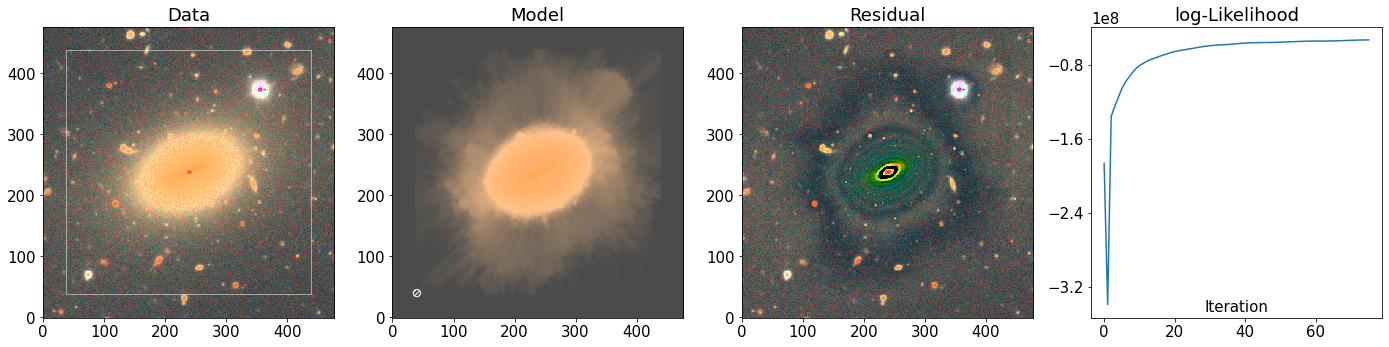

In [136]:
fig = kz.display.display_scarlet_model(
        blend,
        show_ind=[0], #range(1, len(sources)),#[1, 2, 3, 4, 5,],
        zoomin_size=80,
        minimum=-0.3,
        stretch=1,
        Q=1,
        channels=data.channels,
        show_loss=True,
        show_mask=True,
        show_mark=False,
        scale_bar=False)

In [187]:
# Only mask bright stars!!!

# Generate a VERY AGGRESSIVE mask, named "footprint"
footprint = np.zeros_like(segmap_highfreq, dtype=bool)
# for ind in cpct['index']:  # mask ExtendedSources which are modeled
#     footprint[segmap_highfreq == ind + 1] = 1

# footprint[segmap_highfreq == cen_indx_highfreq + 1] = 0
sed_ind_pix = np.array([item.center for item in np.array(
    sources)[sed_ind]]).astype(int)  # the y and x of sed_ind objects
# if any objects in `sed_ind` is in `segmap_highfreq`
# sed_corr_indx = segmap_highfreq[(sed_ind_pix[:, 0], sed_ind_pix[:, 1])]
# for ind in sed_corr_indx:
#     footprint[segmap_highfreq == ind] = 0

# smooth_radius = 1.5
# gaussian_threshold = 0.03
# mask_conv = np.copy(footprint)
# mask_conv[mask_conv > 0] = 1
# mask_conv = convolve(mask_conv.astype(
#     float), Gaussian2DKernel(smooth_radius))
# footprint = (mask_conv >= gaussian_threshold)

### Mask star within the box
if len(star_cat) > 0:
    _, star_mask = kz.utils.gaia_star_mask(  # Generate GAIA mask only for stars outside of the Starlet box
            data.images.mean(axis=0),
            data.wcs,
            gaia_stars=star_cat,
            pixel_scale=pixel_scale,
            gaia_bright=19.0,
            mask_a=694.7, 
            mask_b=3.8,
            factor_b=0.9,
            factor_f=1.0, 
            tigress=True)
    footprint = footprint | star_mask
    
### Mask big objects from `big_cat`
if len(obj_cat_big) > 0:
    # Blow-up radius depends on the distance to target galaxy
    catalog_c = SkyCoord(big_cat['ra'], big_cat['dec'], unit='deg')
    dist = lsbg_coord.separation(catalog_c)
    near_flag = (dist < 4 * cen_obj['a'] * pixel_scale * u.arcsec)
    
    footprint2 = np.zeros_like(segmap_big, dtype=bool)
    for ind in big_cat[near_flag]['index']:  # mask ExtendedSources which are modeled
        footprint2[segmap_big == ind + 1] = 1
    smooth_radius = 1.5
    gaussian_threshold = 0.1
    mask_conv = np.copy(footprint2)
    mask_conv[mask_conv > 0] = 1
    mask_conv = convolve(mask_conv.astype(
        float), Gaussian2DKernel(smooth_radius))
    footprint2 = (mask_conv >= gaussian_threshold)
    
    footprint3 = np.zeros_like(segmap_big, dtype=bool)
    for ind in big_cat[~near_flag]['index']:  # mask ExtendedSources which are modeled
        footprint3[segmap_big == ind + 1] = 1
    smooth_radius = 5
    gaussian_threshold = 0.01
    mask_conv = np.copy(footprint3)
    mask_conv[mask_conv > 0] = 1
    mask_conv = convolve(mask_conv.astype(
        float), Gaussian2DKernel(smooth_radius))
    footprint3 = (mask_conv >= gaussian_threshold)
    
    footprint2 += footprint3 # combine together
    
        # if any objects in `sed_ind` is in `segmap_big`
#     sed_corr_indx = segmap_big[sed_ind_pix[:, 0], sed_ind_pix[:, 1]]
#     for ind in sed_corr_indx:
#         footprint2[segmap_big == ind + 1] = 0
#     footprint2[segmap_big == cen_indx_big + 1] = 0

    footprint = footprint + footprint2 # This is the mask for everything except target galaxy

    2 stars from Gaia are masked!


In [188]:
# zoomin_size: in arcsec, rounded to integer multiple of 30 arcsec
zoomin_size = np.ceil(
    (sources[0].bbox.shape[1] * pixel_scale * 3) / 30) * 30
# cannot exceed the image size
zoomin_size = min(zoomin_size, data.images.shape[1] * pixel_scale)

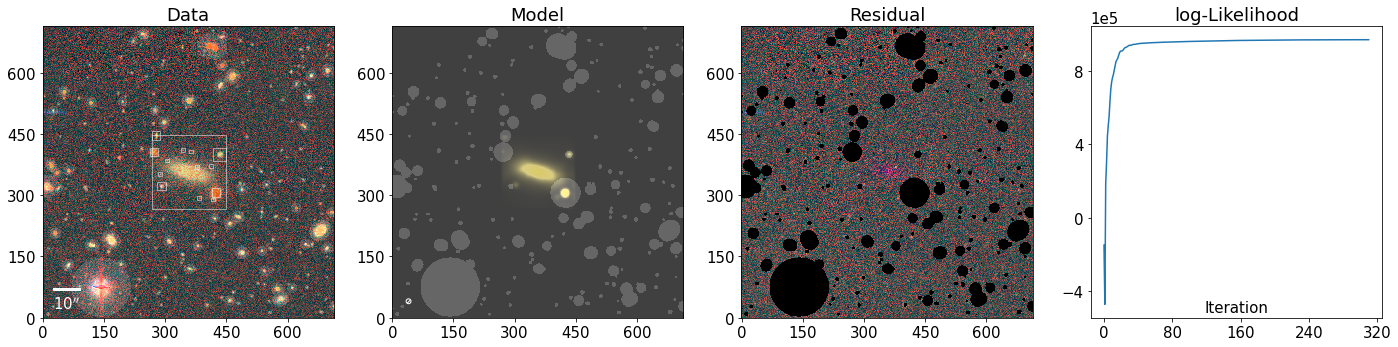

In [189]:
fig = kz.display.display_scarlet_results_tigress(
            blend,
            footprint,
            show_ind=sed_ind,
            zoomin_size=zoomin_size,
            minimum=-0.3,
            stretch=1,
            Q=1,
            channels=data.channels,
            show_loss=True,
            show_mask=False,
            show_mark=False,
            scale_bar=True)